# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
from scipy.stats import norm
from scipy.stats import ttest_ind, ttest_rel, ranksums, wilcoxon

In [2]:
from backend import data_paths
from backend import evaluation_utils
from backend import gauge_groups_utils
from backend import loading_utils

# Load Basin Attributes for Latitude & Longitude

In [3]:
gauges = gauge_groups_utils.get_full_gauge_group()
print(f'There are {len(gauges)} gauges.')

There are 5678 gauges.


In [4]:
attributes = loading_utils.load_attributes_file(gauges=gauges)

# Load Return Period Metrics

In [5]:
_DATASET_RETURN_PERIOD_METRICS_PATH = {
    'google_2014': data_paths.GOOGLE_2014_RETURN_PERIOD_METRICS_DIR,
    'google_1980': data_paths.GOOGLE_1980_RETURN_PERIOD_METRICS_DIR,
    'glofas_2014': data_paths.GLOFAS_v3_REANALYSIS_2014_RETURN_PERIOD_METRICS_DIR,
    'glofas_1980': data_paths.GLOFAS_v3_REANALYSIS_1980_RETURN_PERIOD_METRICS_DIR,
}

In [6]:
precisions_by_lead_time = {}
recalls_by_lead_time = {}

precisions_by_return_period = {}
recalls_by_return_period = {}

for dataset, data_path in _DATASET_RETURN_PERIOD_METRICS_PATH.items():
    print(f'Working on {dataset} ...')
    file_path = data_paths.CONCATENATED_RETURN_PERIOD_DICTS_DIR / f'{dataset}_return_period_dicts.pkl'
    with open(file_path, 'rb') as f:
        precisions_by_lead_time[dataset], recalls_by_lead_time[dataset] = pkl.load(f)
    print(f'Finished loading {dataset}. \n')

Working on google_2014 ...
Finished loading google_2014. 

Working on google_1980 ...
Finished loading google_1980. 

Working on glofas_2014 ...
Finished loading glofas_2014. 

Working on glofas_1980 ...
Finished loading glofas_1980. 



# Calculate F1 Scores from Precision & Recall

In [7]:
f1s_by_lead_time = {
    dataset: {
        experiment: {
            lead_time:
              evaluation_utils.f1_from_precision_and_recall_dfs(
                  precision_df=precisions_by_lead_time[dataset][experiment][lead_time],
                  recall_df=recalls_by_lead_time[dataset][experiment][lead_time]
              ) for lead_time in data_paths.LEAD_TIMES
        } for experiment in precisions_by_lead_time[dataset]
    } for dataset in _DATASET_RETURN_PERIOD_METRICS_PATH
}

# Figure with Histograms

There are 3495 gauges with f1 scores for return period 2.
There are 3236 gauges with f1 scores for return period 5.


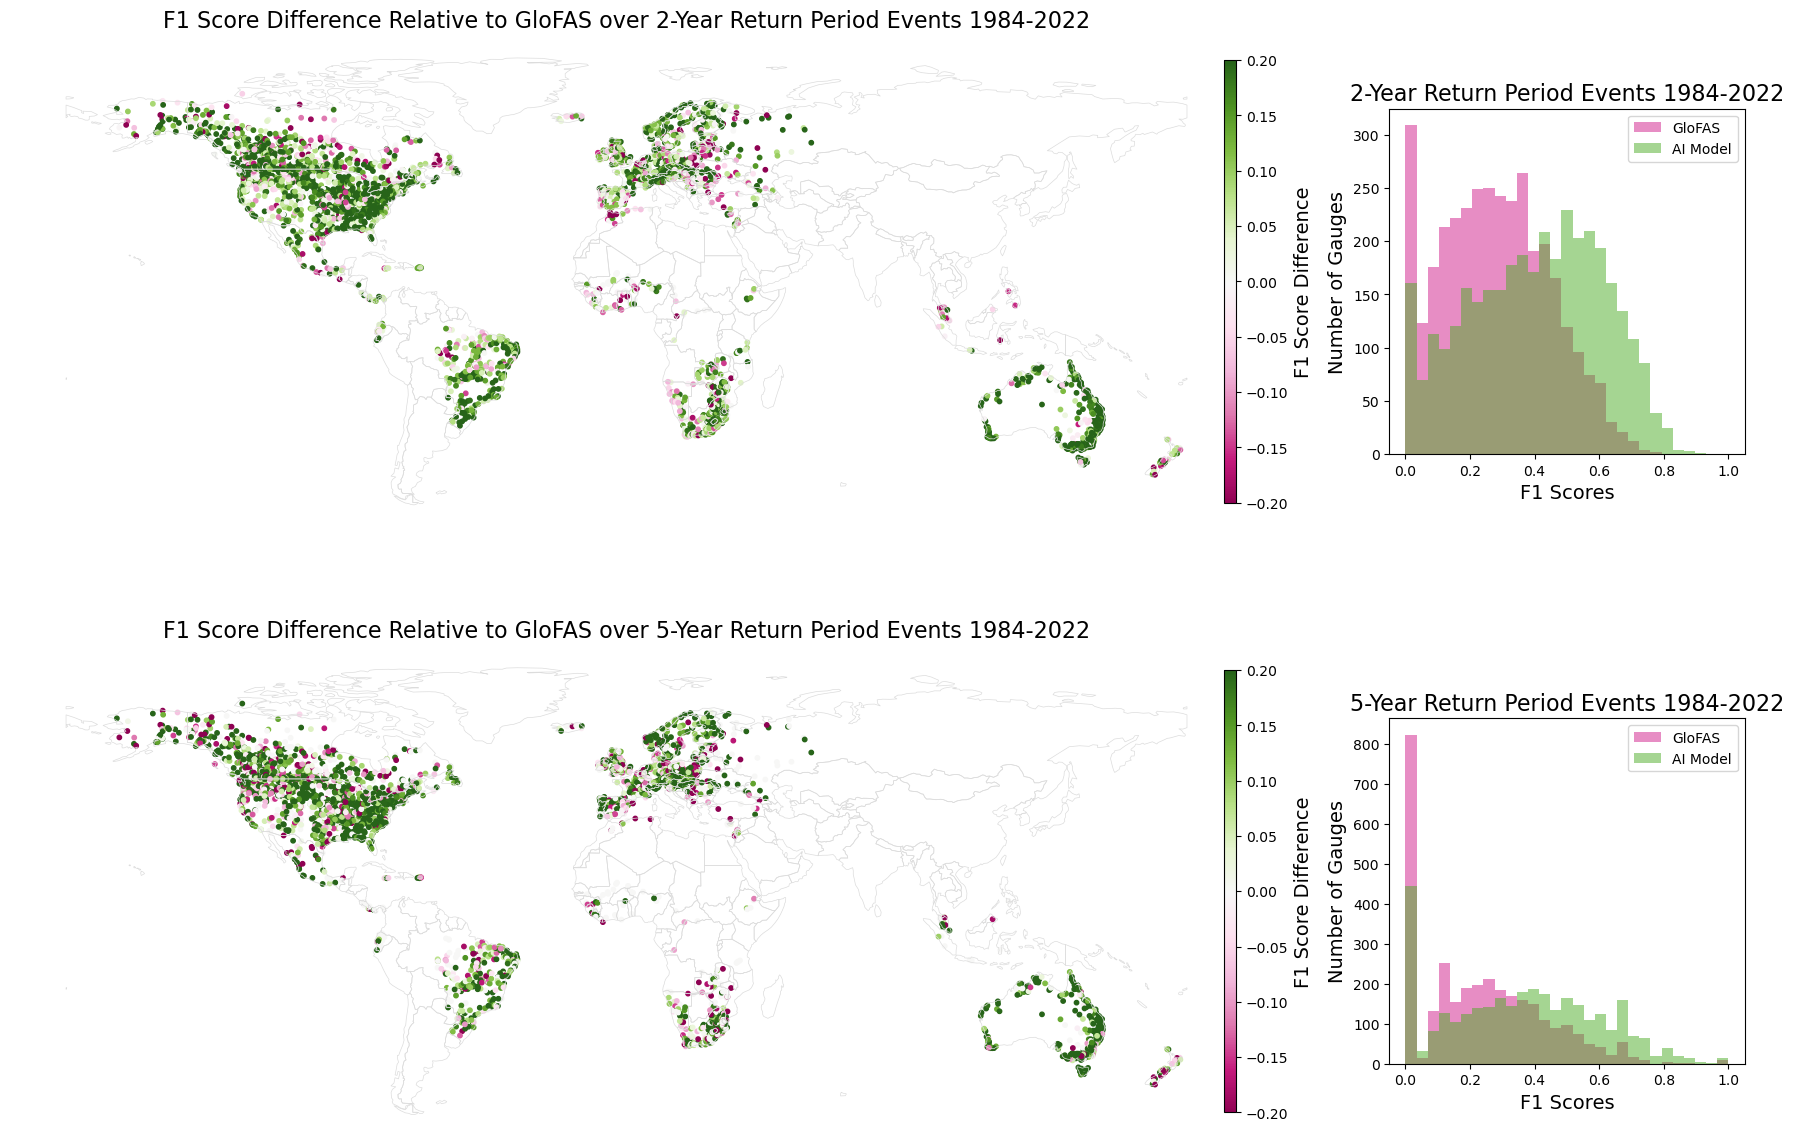

In [8]:
fig, axes = plt.subplots(
    10, 15,
    figsize=(1.5*evaluation_utils.LONGITUDE_FIG_SIZE, 2*evaluation_utils.LATITIDE_FIG_SIZE),
)
nhist_bins = 30

lead_time = 0

for i, return_period in enumerate([2, 5]):

    f1s = pd.concat(
        [
            f1s_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas_reanalysis'),
            f1s_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('kfold_splits')
        ],
        axis=1
    ).dropna()

    metric = 'F1 Score Difference'
    f1s[metric] = f1s['kfold_splits'] - f1s['glofas_reanalysis']

    print(f'There are {f1s.shape[0]} gauges with f1 scores for return period {return_period}.')

    if i == 0:
        gs = axes[0, 0].get_gridspec()
        for ax in axes.flatten():
          ax.remove()
    axbig_start = i*5
    axbig_end = (i+1)*5
    axbig = fig.add_subplot(gs[axbig_start:axbig_end, :10])
    axsmall_start = i*5 + 1
    axsmall_end = (i+1)*5 - 1
    axsmall = fig.add_subplot(gs[axsmall_start:axsmall_end, 11:14])
    
    title = f'{metric} Relative to GloFAS over {int(return_period)}-Year Return Period Events 1984-2022'
    _ = evaluation_utils.spatial_plot(
        latlon=attributes,
        metric=metric,
        title=title,
        metric_data=f1s[metric],
        vmin=-0.2, vmax=0.2,
        ax=axbig,
        cmap='PiYG'
    )

    bins = np.linspace(0, 1, nhist_bins)
    axsmall.hist(
        f1s['glofas_reanalysis'],
        bins,
        alpha=0.5,
        label=evaluation_utils.EXPERIMENT_NAMES['glofas_reanalysis'],
        color='#d01c8b'
    )
    axsmall.hist(
        f1s['kfold_splits'],
        bins,
        alpha=0.5,
        label=evaluation_utils.EXPERIMENT_NAMES['kfold_splits'],
        color='#4dac26'
    )
    axsmall.legend(loc='upper right')
    axsmall.set_title(f'{int(return_period)}-Year Return Period Events 1984-2022', fontsize=16)
    axsmall.set_xlabel('F1 Scores', fontsize=14)
    axsmall.set_ylabel('Number of Gauges', fontsize=14)

# Figure without Histograms

There are 3236 gauges with f1 scores for return period 5.0.


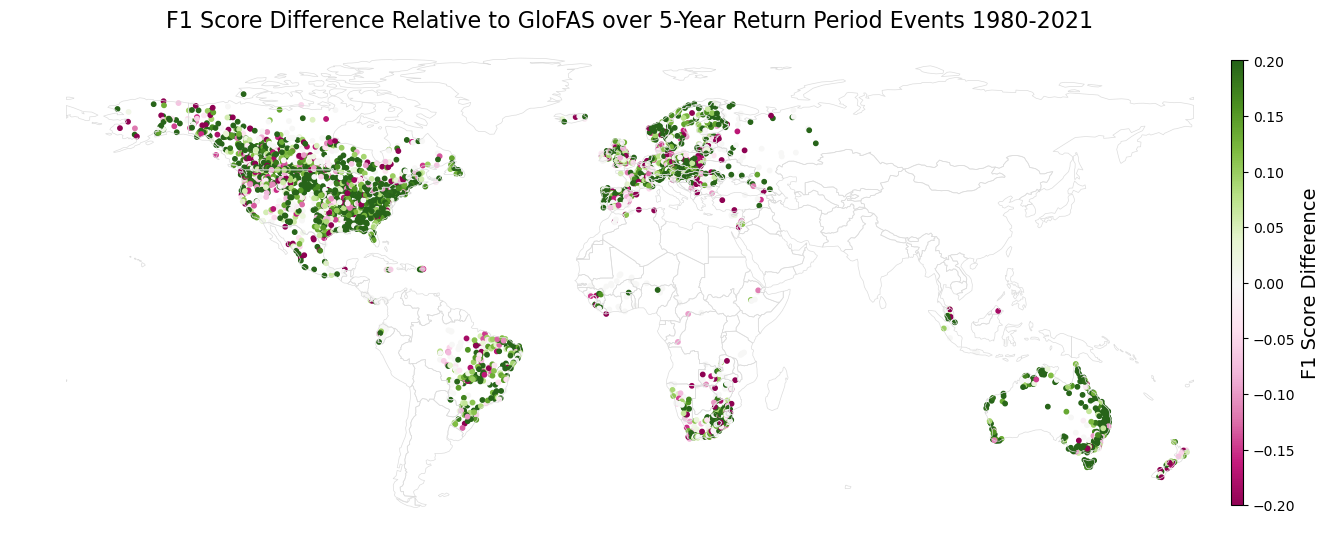

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(evaluation_utils.LONGITUDE_FIG_SIZE, 2*evaluation_utils.LATITIDE_FIG_SIZE))

lead_time = 0
return_period = 5.00

f1s = pd.concat(
    [
        f1s_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas'),
        f1s_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('google')
    ],
    axis=1
).dropna()

metric = 'F1 Score Difference'
f1s[metric] = f1s['google'] - f1s['glofas']

print(f'There are {f1s.shape[0]} gauges with f1 scores for return period {return_period}.')

title = f'{metric} Relative to GloFAS over {int(return_period)}-Year Return Period Events 1980-2021'
_ = evaluation_utils.spatial_plot(
    latlon=attributes,
    metric=metric,
    title=title,
    metric_data=f1s[metric],
    vmin=-0.2, vmax=0.2,
    ax=axes,
    cmap='PiYG'
)

# Save figure
evaluation_utils.save_figure(data_paths.GLOBAL_F1_SCORES_MAP_FILENAME)

# Fraction of Improved Basins

In [10]:
metric = 'F1 Score Difference'

for return_period in evaluation_utils.RETURN_PERIODS:

    print(f'--- Return Period = {return_period} -------------------------------------------')

    f1s = pd.concat(
      [
          f1s_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas'),
          f1s_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('google')
      ],
      axis=1
    ).dropna()
    f1s[metric] = f1s['google'] - f1s['glofas']

    print('Total number of gauges: ', f1s.shape[0])
    print('Gauges with nonnegative differences: ', f1s[f1s[metric] >= 0].shape[0])
    print('Fraction with nonnegative differences: ', f1s[f1s[metric] >= 0].shape[0] / f1s.shape[0])
    print('Fraction with positive differences: ', f1s[f1s[metric] > 0].shape[0] / f1s.shape[0])

    print('\n')
#     print(ttest_ind(f1s['google'],f1s['glofas']))
#     print(ttest_rel(f1s['google'],f1s['glofas']))
#     print(ranksums(f1s['google'],f1s['glofas']))
    stats = wilcoxon(f1s['google'],f1s['glofas'])
    cohen_d = evaluation_utils.cohen_d(f1s['google'].values, f1s['glofas'].values)
    zstatistic = norm.isf(stats.pvalue / 2)
    effect_size = zstatistic / f1s.shape[0]**(1/2)
    print(stats, effect_size, cohen_d)

    print('-------------------------------------------------------------------- \n\n')


--- Return Period = 1.01 -------------------------------------------
Total number of gauges:  3497
Gauges with nonnegative differences:  2664
Fraction with nonnegative differences:  0.761795824992851
Fraction with positive differences:  0.7520732056048041


WilcoxonResult(statistic=971508.0, pvalue=3.630127494192694e-260) 0.5826666701282922 0.520469119445528
-------------------------------------------------------------------- 


--- Return Period = 2 -------------------------------------------
Total number of gauges:  3495
Gauges with nonnegative differences:  2834
Fraction with nonnegative differences:  0.8108726752503577
Fraction with positive differences:  0.7805436337625179


WilcoxonResult(statistic=715039.0, pvalue=0.0) inf 0.6715780333397089
-------------------------------------------------------------------- 


--- Return Period = 5 -------------------------------------------
Total number of gauges:  3236
Gauges with nonnegative differences:  2528
Fraction with nonnegative diff